In [62]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                       Dense, Dropout, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [63]:
# ==================== CONFIGURATION ====================
IMG_SIZE = 128
BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS = 50
SEED = 42

age_group_labels = [
    'Child (0-10)',
    'Teenager (11-17)',
    'Adult (18-35)',
    'Middle Age (36-59)',
    'Senior (60+)'
]

In [64]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [65]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [66]:

import shutil


# ==================== HELPER FUNCTIONS ====================
def age_to_group(age):
    """Convert numerical age to age group index"""
    if age <= 10:
        return 0
    elif 11 <= age <= 17:
        return 1
    elif 18 <= age <= 35:
        return 2
    elif 36 <= age <= 59:
        return 3
    else:
        return 4

In [67]:
def plot_class_distribution(df, title="Class Distribution"):
    """Plot the distribution of classes"""
    plt.figure(figsize=(10, 5))
    counts = df['class'].value_counts().sort_index()
    labels = [age_group_labels[int(i)] for i in counts.index]
    plt.bar(labels, counts.values, color='skyblue', edgecolor='black')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for i, v in enumerate(counts.values):
        plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()

In [68]:
# ==================== DATA PREPARATION ====================
print("=" * 60)
print("LOADING DATA")
print("=" * 60)

data_dir = r"/content/UTKFace"
files = os.listdir(data_dir)


LOADING DATA


In UTKFace, the labels are encoded directly in the image filenames.



Each file has the format:

[age] _[gender] _[race] _[date&time].jpg


age → integer (0–116)

gender → 0 = male, 1 = female

race → 0 = White, 1 = Black, 2 = Asian, 3 = Indian, 4 = Others

date&time → not needed for labels

Example:

25_0_2_20170116174525125.jpg


means:

Age = 25

Gender = 0 (male)

Race = 2 (Asian)

In [69]:
# Parse filenames to extract ages
ages = []
valid_files = []
for f in files:
    try:
        age = int(f.split("_")[0])
        ages.append(age)
        valid_files.append(f)
    except:
        continue

age_groups = [age_to_group(a) for a in ages]

In [70]:
# Create dataframe
df = pd.DataFrame({
    "filename": valid_files,
    "class": age_groups
})
df["class"] = df["class"].astype(str)

print(f"\nTotal images: {len(df)}")
print(f"\nClass distribution:")
for i in range(NUM_CLASSES):
    count = (df['class'] == str(i)).sum()
    print(f"  {age_group_labels[i]}: {count}")



Total images: 23708

Class distribution:
  Child (0-10): 3218
  Teenager (11-17): 1015
  Adult (18-35): 10874
  Middle Age (36-59): 5911
  Senior (60+): 2690


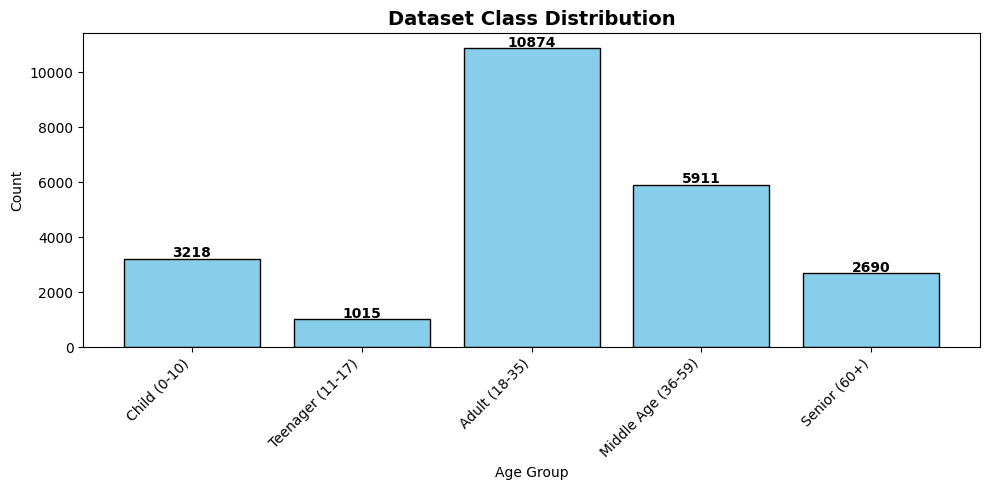

In [71]:
plot_class_distribution(df, "Dataset Class Distribution")


In [72]:
# Split data
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['class'],
    random_state=SEED
)

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


Training samples: 18966
Validation samples: 4742


In [73]:

# Parse filenames to extract ages
ages = []
valid_files = []
for f in files:
    try:
        age = int(f.split("_")[0])
        ages.append(age)
        valid_files.append(f)
    except:
        continue

age_groups = [age_to_group(a) for a in ages]




In [74]:
# ==================== DATA GENERATORS ====================
print("\n" + "=" * 60)
print("CREATING DATA GENERATORS")
print("=" * 60)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=data_dir,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("\nData generators created successfully!")



CREATING DATA GENERATORS
Found 18966 validated image filenames belonging to 5 classes.
Found 4742 validated image filenames belonging to 5 classes.

Data generators created successfully!


In [75]:
# Split data
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['class'],
    random_state=SEED
)

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


Training samples: 18966
Validation samples: 4742


In [76]:
# ==================== DATA GENERATORS ====================
print("\n" + "=" * 60)
print("CREATING DATA GENERATORS")
print("=" * 60)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=data_dir,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("\nData generators created successfully!")


CREATING DATA GENERATORS
Found 18966 validated image filenames belonging to 5 classes.
Found 4742 validated image filenames belonging to 5 classes.

Data generators created successfully!


# Custom Build Model

In [77]:

# # ==================== MODEL ARCHITECTURE ====================
# print("\n" + "=" * 60)
# print("BUILDING MODEL")
# print("=" * 60)

# model = Sequential([
#     # Block 1
#     Conv2D(64, (3, 3), activation='relu', padding='same',
#            input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#     BatchNormalization(),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.25),

#     # Block 2
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.3),

#     # Block 3
#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.35),

#     # Block 4
#     Conv2D(512, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(512, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.4),

#     # Global pooling and dense layers
#     GlobalAveragePooling2D(),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.4),
#     Dense(NUM_CLASSES, activation='softmax')
# ])

# Transfer Learning

In [78]:
from keras.applications.vgg16 import VGG16
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False, #for excluding the dense layers
    input_shape = (128,128,3)
)
conv_base.trainable = False
# Let's unfreeze from 'block5_conv1' onwards
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
conv_base.summary()
# ==================== MODEL ARCHITECTURE ====================
print("\n" + "=" * 60)
print("BUILDING MODEL")
print("=" * 60)

model = Sequential([
    conv_base,
    # Global pooling and dense layers
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])




Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)


BUILDING MODEL


In [79]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,113,029 (57.65 MB)

 Trainable params: 7,476,229 (28.52 MB)

 Non-trainable params: 7,636,800 (29.13 MB)

In [80]:

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [81]:
# ==================== CALLBACKS ====================
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [82]:
# ==================== TRAINING ====================
print("\n" + "=" * 60)
print("TRAINING MODEL")
print("=" * 60)

history = model.fit(
    train_gen,
    epochs=45,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)


TRAINING MODEL


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/45
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4441 - loss: 1.6186
Epoch 1: val_accuracy improved from -inf to 0.68030, saving model to best_model.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 139s 224ms/step - accuracy: 0.4442 - loss: 1.6182 - val_accuracy: 0.6803 - val_loss: 0.9258 - learning_rate: 1.0000e-04
Epoch 2/45
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6165 - loss: 1.0755
Epoch 2: val_accuracy did not improve from 0.68030
593/593 ━━━━━━━━━━━━━━━━━━━━ 126s 213ms/step - accuracy: 0.6165 - loss: 1.0754 - val_accuracy: 0.6038 - val_loss: 1.1367 - learning_rate: 1.0000e-04
Epoch 3/45
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6597 - loss: 0.8877
Epoch 3: val_accuracy improved from 0.68030 to 0.70245, saving model to best_model.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 124s 208ms/step - accuracy: 0.6597 - loss: 0.8877 - val_accuracy: 0.7024 - val_loss: 0.7705 - learning_rate: 1.0000e-04
Epoch 4/45
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accurac


TRAINING RESULTS


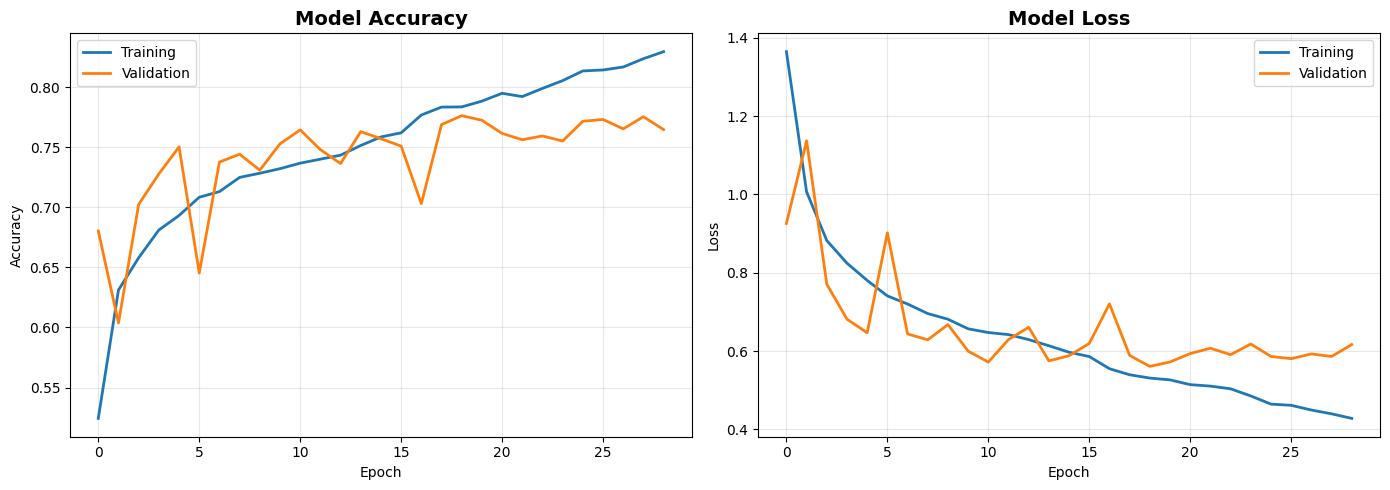

In [83]:
# ==================== TRAINING VISUALIZATION ====================
print("\n" + "=" * 60)
print("TRAINING RESULTS")
print("=" * 60)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [84]:
# ==================== EVALUATION ====================
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc*100:.2f}%")


MODEL EVALUATION

Validation Loss: 0.5609
Validation Accuracy: 77.63%


In [85]:
# Get predictions
val_gen.reset()
predictions = model.predict(val_gen, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_gen.classes

In [86]:
# Classification report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(true_classes, predicted_classes,
                          target_names=age_group_labels, digits=3))


CLASSIFICATION REPORT
                    precision    recall  f1-score   support

      Child (0-10)      0.905     0.927     0.916       644
  Teenager (11-17)      0.608     0.360     0.452       203
     Adult (18-35)      0.785     0.911     0.843      2175
Middle Age (36-59)      0.686     0.555     0.614      1182
      Senior (60+)      0.775     0.693     0.732       538

          accuracy                          0.776      4742
         macro avg      0.752     0.689     0.711      4742
      weighted avg      0.768     0.776     0.767      4742



In [87]:
# Get predictions - Make sure this runs BEFORE the per-class accuracy section
val_gen.reset()
predictions = model.predict(val_gen, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels - THIS IS THE KEY FIX
true_classes = np.array(val_gen.classes)  # Convert to NumPy array

# Per-class accuracy
print("\n" + "=" * 60)
print("PER-CLASS ACCURACY")
print("=" * 60)
for i in range(NUM_CLASSES):
    mask = true_classes == i
    if mask.sum() > 0:
        correct = (predicted_classes[mask] == true_classes[mask]).sum()
        total = mask.sum()
        accuracy = correct / total
        print(f"{age_group_labels[i]:20s}: {accuracy:.3f} ({accuracy*100:5.1f}%) - {correct:4d}/{total:4d} correct")


PER-CLASS ACCURACY
Child (0-10)        : 0.927 ( 92.7%) -  597/ 644 correct
Teenager (11-17)    : 0.360 ( 36.0%) -   73/ 203 correct
Adult (18-35)       : 0.911 ( 91.1%) - 1982/2175 correct
Middle Age (36-59)  : 0.555 ( 55.5%) -  656/1182 correct
Senior (60+)        : 0.693 ( 69.3%) -  373/ 538 correct


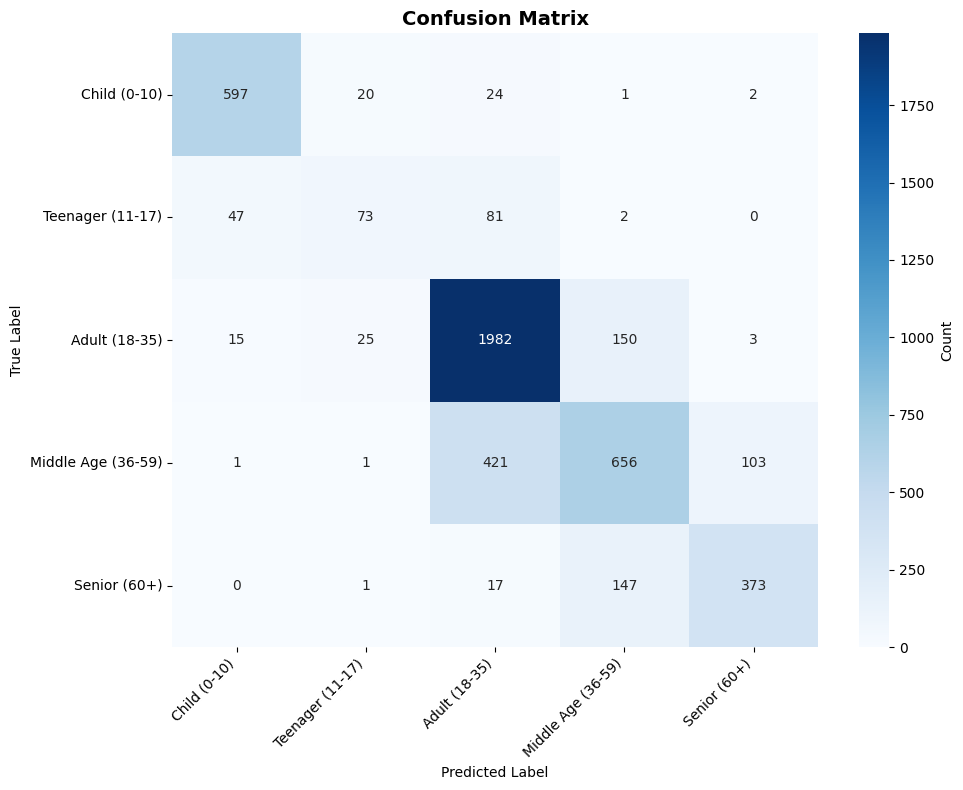

In [88]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=age_group_labels,
            yticklabels=age_group_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


VISUALIZING SAMPLE PREDICTIONS


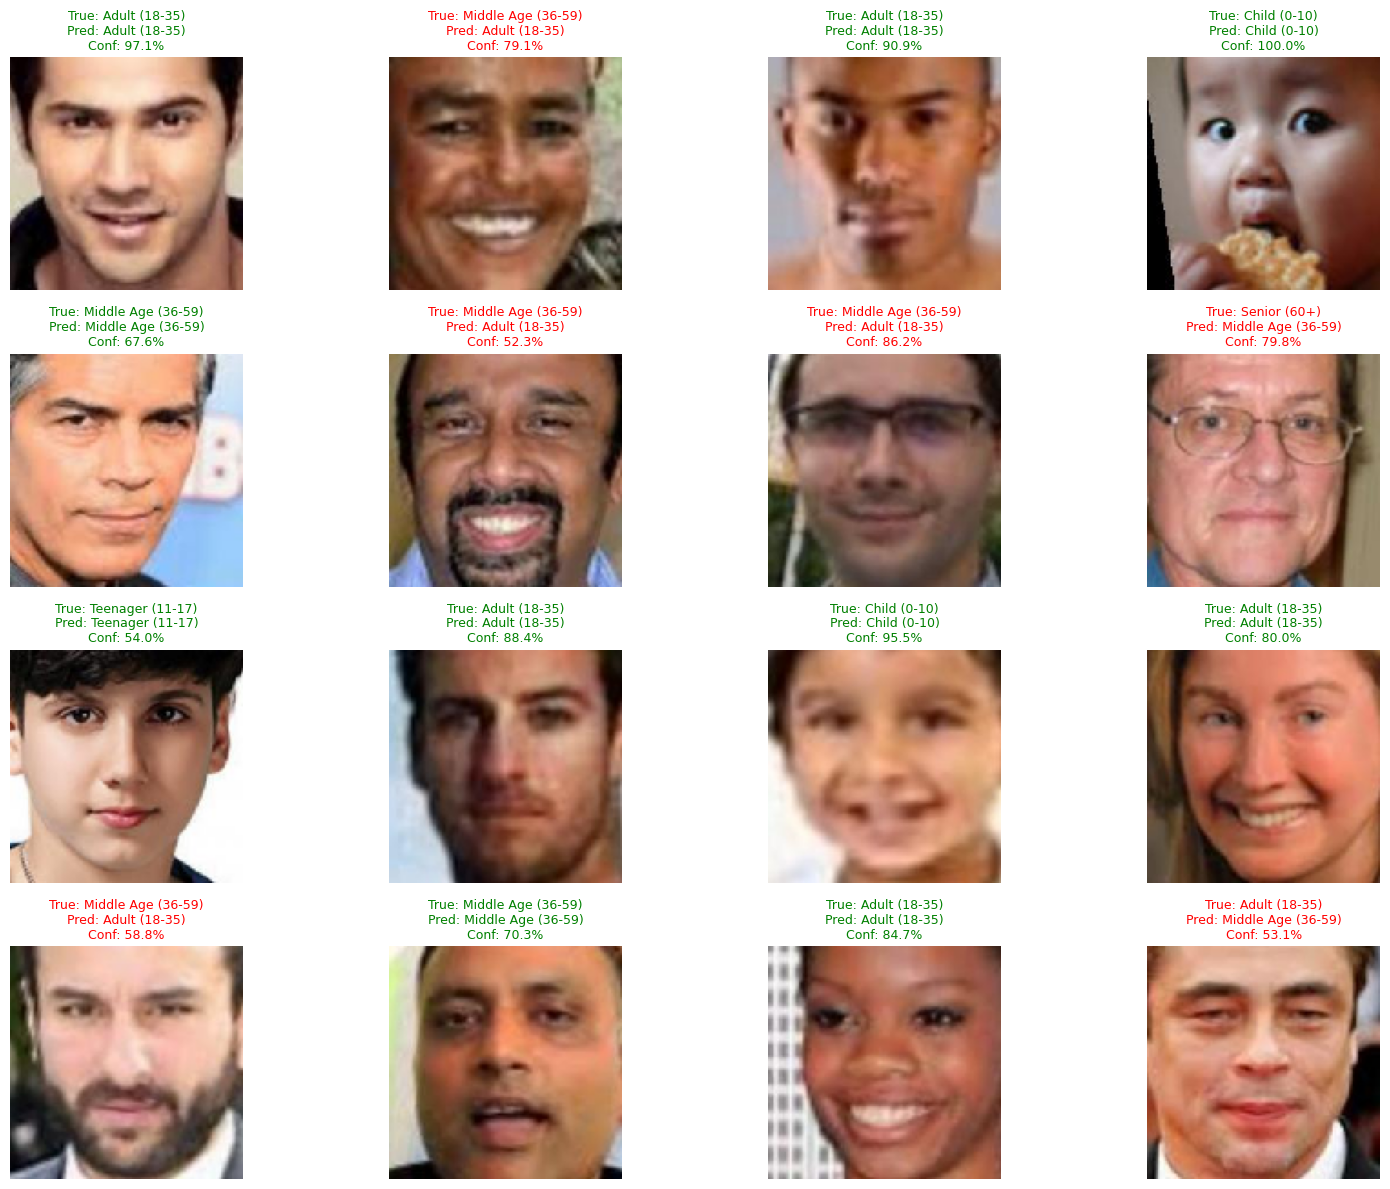

In [89]:
# ==================== SAMPLE PREDICTIONS ====================
print("\n" + "=" * 60)
print("VISUALIZING SAMPLE PREDICTIONS")
print("=" * 60)

val_gen.reset()
x_batch, y_batch = next(val_gen)
predictions_batch = model.predict(x_batch, verbose=0)

plt.figure(figsize=(16, 12))
for i in range(min(16, len(x_batch))):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_batch[i])

    true_idx = np.argmax(y_batch[i])
    pred_idx = np.argmax(predictions_batch[i])
    confidence = predictions_batch[i][pred_idx] * 100

    color = 'green' if true_idx == pred_idx else 'red'

    plt.title(f'True: {age_group_labels[true_idx]}\n'
             f'Pred: {age_group_labels[pred_idx]}\n'
             f'Conf: {confidence:.1f}%',
             color=color, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [90]:
# ==================== SAVE MODEL ====================
model.save("age_classification_final.keras")
print("\n" + "=" * 60)
print("MODEL SAVED: age_classification_final.keras")
print("=" * 60)


MODEL SAVED: age_classification_final.keras


In [91]:
# ==================== PREDICTION FUNCTION ====================
def predict_age_from_image(image_path):
    """
    Predict age group for a single image

    Args:
        image_path: Path to the image file

    Returns:
        predicted_class: Index of predicted class
        confidence: Confidence percentage
    """
    from tensorflow.keras.preprocessing import image

    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class] * 100

    print(f"\nPrediction for: {image_path}")
    print(f"Age Group: {age_group_labels[predicted_class]}")
    print(f"Confidence: {confidence:.2f}%")
    print("\nAll probabilities:")
    for i, prob in enumerate(prediction[0]):
        print(f"  {age_group_labels[i]:20s}: {prob*100:5.2f}%")

    return predicted_class, confidence

print("\n" + "=" * 60)
print("PROJECT COMPLETE!")
print("=" * 60)
print("\nTo predict on a new image, use:")
print(predict_age_from_image('/content/sample.jpg'))


PROJECT COMPLETE!

To predict on a new image, use:

Prediction for: /content/sample.jpg
Age Group: Adult (18-35)
Confidence: 73.19%

All probabilities:
  Child (0-10)        : 14.83%
  Teenager (11-17)    : 10.39%
  Adult (18-35)       : 73.19%
  Middle Age (36-59)  :  1.46%
  Senior (60+)        :  0.12%
(np.int64(2), np.float32(73.19267))
